# Sentence similarities based on Word2vec embbeddings

### imports

In [4]:
#import PyPDF2
#import textract
import os

import numpy as np
import pandas as pd
import seaborn as sns

import nltk
from gensim.models import word2vec
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import metrics, datasets, neighbors, decomposition

In [5]:
#gg_vectors = api.load("glove-wiki-gigaword-100")

### get data

In [11]:
df = pd.read_csv('../data/processed/supreme_court_opinions_2013_tokenized.csv', converters={
    'nltk_tokenized': eval, 
    "nltk_sentences": eval,
    'nltk_sentences_tok': eval
    }).drop('Unnamed: 0', axis = 1)
#df['nltk_tokenized'] = pd.eval(df['nltk_tokenized'])
#df['nltk_sentences'] = pd.eval(df['nltk_sentences'])

In [12]:
df['raw text'] = df['raw text'].apply(lambda x: x.replace('\n-',''))
df['raw text'] = df['raw text'].apply(lambda x: x.replace('\n',''))
df

,raw text,nltk_sentences,nltk_tokenized,nltk_sentences_tok
0,1 (S...,[ \n \n \n \n \n...,"[1, (, slip, opinion, ), october, term, ,, 201...","[[1, (, slip, opinion, ), october, term, ,, 20..."
1,1 (Slip Opinio...,[ \n \n 1 (Slip O...,"[1, (, slip, opinion, ), october, term, ,, 201...","[[1, (, slip, opinion, ), october, term, ,, 20..."
2,1 (...,[ \n \n ...,"[1, (, slip, opinion, ), october, term, ,, 201...","[[1, (, slip, opinion, ), october, term, ,, 20..."
3,1 (Slip Opi...,[ \n \n \n 1 (S...,"[1, (, slip, opinion, ), october, term, ,, 201...","[[1, (, slip, opinion, ), october, term, ,, 20..."
4,1...,[ \n \n ...,"[1, (, slip, opinion, ), october, term, ,, 201...","[[1, (, slip, opinion, ), october, term, ,, 20..."
...,...,...,...,...
67,1 (Slip O...,[ \n \n \n \n ...,"[1, (, slip, opinion, ), october, term, ,, 201...","[[1, (, slip, opinion, ), october, term, ,, 20..."
68,1 Cite as: 572 U. S...,[ \n \n 1 Cite as: 572...,"[1, cite, :, 572, u., s., ____, (, 2014, ), pe...","[[1, cite, :, 572, u., s., ____, (, 2014, ), p..."
69,1 Cite as: 572 U. S. ____ (20...,[ 1 Cite as: 572 U. S. ____ (2...,"[1, cite, :, 572, u., s., ____, (, 2014, ), pe...","[[1, cite, :, 572, u., s., ____, (, 2014, ), p..."
70,1 Cite as: 571 U. S. ____ (2...,[ \n 1 Cite as: 571 U. S. ____...,"[1, cite, :, 571, u., s., ____, (, 2014, ), pe...","[[1, cite, :, 571, u., s., ____, (, 2014, ), p..."


### raw text readable (ish): 

In [13]:
all_sentences = []
for text in df['nltk_sentences']:
    for sentence in text:
        sentence_p = sentence.replace('\n-','')
        sentence_p = sentence_p.replace('\n','')
        all_sentences.append(sentence_p)

In [230]:
len(all_sentences)

33741

### build corpus to get word embeddings from: 

In [200]:
corpus = []
for i in df['nltk_sentences_tok']:
    for j in i:
        corpus.append(j)

### and get the word embeddings:

In [283]:
model_w = word2vec.Word2Vec(corpus, size=100, window=100, min_count=5, workers=4)
model_n = word2vec.Word2Vec(corpus, size=100, window=3, min_count=5, workers=4)
# something to fill afterwards whith the mixed embeddings
model_mix = word2vec.Word2Vec(corpus, size = 100, window = 1, min_count = 100, workers = 4) 

In [392]:
print(model_w.wv.most_similar('jury', topn=5))
print(model_n.wv.most_similar('jury', topn=5))
print(model_nada.wv.most_similar('jury', topn=5))

[('grand', 0.9626011252403259), ('entitled', 0.9462876319885254), ('discretion', 0.9453582763671875), ('judge', 0.9447222948074341), ('wisconsin™s', 0.9378288984298706)]
[('grand', 0.9785374999046326), ('determine', 0.9782351851463318), ('hearing', 0.9733443856239319), ('determining', 0.9699631333351135), ('proper', 0.9686853885650635)]
[('grand', 0.9380059242248535), ('proper', 0.9327932596206665), ('reach', 0.9322798252105713), ('never', 0.9317858219146729), ('taken', 0.915726900100708)]


In [390]:
# this I didn't use for anything
vectors_w = model_w.wv
vectors_n = model_n.wv

### create a "mixture" of two embeddings whit PCA:

In [ ]:
keys = model_w.wv.vocab.keys()
# model_w.wv.vocab['1']

In [393]:
embeddings_w = pd.DataFrame({key:model_w.wv[key] for key in keys})
embeddings_n = pd.DataFrame({key:model_n.wv[key] for key in keys})
embeddings_all = embeddings_w.append(embeddings_n).T

In [362]:
pca = decomposition.PCA()
pca.fit(embeddings_all)
embeddings_PCA = pca.transform(embeddings_all).T

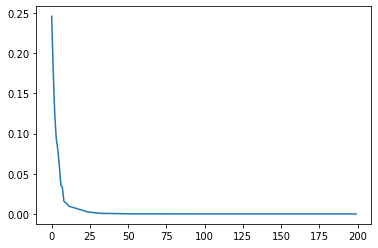

In [371]:
sns.lineplot(x = range(0,len(pca.components_)), y = pca.explained_variance_ratio_)

In [405]:
total_explained =pd.Series(pca.explained_variance_ratio_).cumsum()

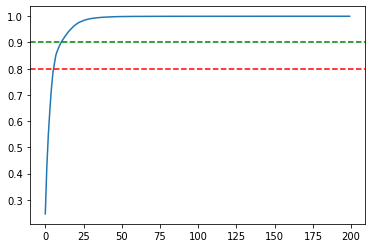

In [374]:
ax1 = sns.lineplot(x = range(0,len(pca.components_)), y = total_explained)
ax1.axhline(y=0.8, color="red", linestyle="--")
ax1.axhline(y=0.9, color="green", linestyle="--")

In [407]:
embeddings_mix = pd.DataFrame(embeddings_PCA).iloc[:,0:100]
embeddings_mix['word'] = embeddings_all.index.values
embeddings_mix.set_index(['word'], inplace = True)
#embeddings_mix'

In [420]:
#model_mix = word2vec.Word2Vec(corpus, size = 100, window = 1, min_count = 100, workers = 4) 
for word in keys:
    model_mix.wv[word] = np.array(embeddings_mix.loc[word])

### create a function tha calculates embeddings for sentences :
Embeddigns are based on averages of words

In [114]:
def get_sentence_vector(sentence, model):
    try:
        vector = pd.DataFrame([model.wv[word] for word in sentence]).mean()
    except:
        vector = pd.DataFrame([list(range(100)) for i in [1,2]]).mean() 
    return vector

In [202]:
###     T H I S   T A K E S    A    W H I L E  !!!

sentence_vectors_w = pd.DataFrame([get_sentence_vector(sent,model_w) for sent in corpus])
sentence_vectors_n = pd.DataFrame([get_sentence_vector(sent,model_n) for sent in corpus])
sentence_vectors_mix = pd.DataFrame([get_sentence_vector(sent,model_mix) for sent in corpus])

In [421]:
sentence_vectors_mix = pd.DataFrame([get_sentence_vector(sent,model_mix) for sent in corpus])

#### (tokenizer)

In [242]:
STOP_WORDS = nltk.corpus.stopwords.words('english')

In [385]:
# tokenizer function same as in preprocess notebook
def tokenize_text(text):    
    text_tokenized = nltk.word_tokenize(text)
    text_tokenized = list(map(lambda x: x.lower(),text_tokenized))
    
    for word in text_tokenized:        
        if word in STOP_WORDS:
            text_tokenized.remove(word)
        #if not (word.isalnum()):            
            #text_tokenized.remove(word)
        
    return(text_tokenized)

### create a function that fetches the most similar sentences to an expression:
Embeddigns are based on averages of words

In [386]:
def get_most_similar (input, model, sentence_vectors, n):
    input = tokenize_text(input)
    input_vector = get_sentence_vector(input, model)
    sim = cosine_similarity(sentence_vectors, np.array(input_vector).reshape(1, -1)).T[0]
    toplist = pd.DataFrame({'sentences': all_sentences, 'similarity': sim}).sort_values(by = 'similarity', ascending = False)[0:n]
    return(toplist)

In [429]:
#search_term = 'deny'
search_term = 'The Court objects'
top10_wide = get_most_similar(search_term, model_w,sentence_vectors_w,10)
top10_narrow = get_most_similar(search_term, model_n,sentence_vectors_n,10)
top10_narrow = get_most_similar(search_term, model_mix,sentence_vectors_mix,10)

print('WIDE: ')
for i in top10_wide['sentences']:
    print(i)
    print()
    
print('NARROW: ')
for i in top10_narrow['sentences']:
    print(i)
    print()
    
print('MIX: ')
for i in top10_narrow['sentences']:
    print(i)
    print()

WIDE: 
The judgment of the Court of Appeals is reversed.

The judgment of the Court of Appeals is affirmed.

We reverse the judgment of the Court of Appeals.

We therefore reverse the judgment of the Court of Appeals.

The Bankruptcy Court granted summary judgment in its favor.

The Court granted certiorari.

This Court granted certiorari.

This Court granted certiorari.

The judgment of the Court of Appeals for the Sixth Circuit is reversed.

The District Court granted summary judgment to Octane.

NARROW: 
The court refused, and the Kentucky Supreme Court agreed that no instruction was warranted.

This Court granted certiorari.

This Court granted certiorari.

The Court granted certiorari.

The Court has properlyreserved that issue for consideration on remand.

The Bankruptcy Court granted summary judgment in its favor.

The Court of Appeals once againaffirmed.

The California Court of Appeal affirmed.

The California Court of Appeal affirmed.

The California Court of Appeal affirmed.

In [384]:
 #get_sentence_vector(tokenize_text('judgment of the California Court'), model_w).T